## Pre-Trained Model 이용 캡차 숫자인식하기
ILSVRC(ImageNet Large-Scale Visual Recognition Challenge)란 컴퓨터 비전 분야의 '올림픽'으로 불리우는 대회이다. 아마도 딥러닝을 공부한 사람들이라면 한번 쯤 AlexNet이나 VGG, GoogleNet, ResNet에 대해 들어보았을 것이다. 이는 모두 ILSVRC 대회에서 매년 우승을 거머쥐었던 모델이다.
![ImageNet Classfication](images/MicrosoftImagNetResults.png)

출처 : https://www.bdti.com/InsideDSP/2017/06/29/Microsoft

Tranfer Learning과 ILSVRC가 무슨 연관이 있지? 라는 생각이 들텐데, 놀랍게도 우리는 ImageNet Classfication 대회에서 우승했던 모델과 그 가중치를 가져와 쓸 수 있는데, 이것이 바로 앞서 언급 했던 Pre-Trained Model이다.
![ResNet34](images/resnet34.png)

도대체 어떻게하면 이렇게 'Deep한' 모델을 가져다 쓸 수 있을까.

**model_ft = models.resnet18(pretrained=True)** 오늘의 핵심을 단 한 줄로 설명하면 바로 이 코드가 되겠다. torchvision 라이브러리에서는 ResNet 시리즈와 VGG 시리즈 등 ImageNet의 모든 대표작들을 잘 구현해 놓았다. 따라서 우리는 라이브러리에서 꺼내 쓰기만 하면 되는 것이다. 또한 Pre-Trained Weights의 경우, 모델을 불러올 때 파라미터로 pretrained=True 값만 입력해주면 자동으로 Weights 값을 불러올 수 있다.


**```model_ft = models.resnet18(pretrained=True)```**


여기서는 Pre-Trained Model을 이용하기 보다는 캡차 이미지의 숫자인식 성능을 높이기 위해 검증된 모델을 이용 하겠으며,

**```model_ft = models.resnet18(pretrained=False)```**


이상과 같이 pretrained=False로 주고 활용 합니다.

In [9]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models
from pathlib import Path
# from fastai.vision import Path
import torch
import torch.nn as nn
from torch.autograd import Variable

### 목적변수 처리를 위한 OneHot Vector 생성준비

In [10]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 5

In [11]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

### 종속변수 처리를 위한 데이터셋 불러오기
torch.utils.data.DataLoader를 이용해서 입력 데이터를 불러온다. DataLoader의 입력 파라미터로는 (경로, Transform 옵션)을 포함하는 ImageFolder함수와 배치사이즈, 그리고 셔플 옵션이 있다. DataLoader의 파라미터 중 하나인 num_workers는 스레드 갯수를 설정하는 것인데, 필자의 경우 4로 했을 때 오류가 발생해서 스레드 갯수를 0으로 설정했다.

​

* 처음 볼 땐 난해한 문법들이 많을 텐데, 파이썬 딕셔너리 자료형에 대한 개념을 안다면 무난하게 이해할 수 있다. 잘 이해가 안된다면 딕셔너리 자료형에 대한 내용을 한번 읽고 오도록 하자.

In [12]:
class Mydataset(Dataset):
    def __init__(self, path, is_train=True, transform=None):
        self.path = path
        if is_train: self.img = os.listdir(self.path)[:1000]
        else: self.img = os.listdir(self.path)[1001:]
        try: self.img.remove('3bnfnd.png')
        except: pass
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(self.path/img_path)
        img = img.convert('L')
        label = Path(self.path/img_path).name[:-4]
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [13]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [14]:
train_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), transform=transform)
test_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), False, transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(train_ds, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

일부 이미지 시각화하기 ^^^^^^^^^^^^^^^^^^^^^^^^^ 데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

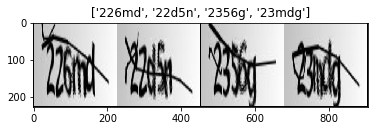

In [25]:
import matplotlib.pylab as plt
import numpy as np

# def imshow(img):
#     img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg,(1,2,0)))
#     plt.show()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# 학습 데이터의 배치를 얻습니다.
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 64로 했으니 사진 64장이 로드된다.
dataiter = iter(train_dl)
inputs, label_oh, classes = dataiter.next()


# 배치로부터 격자 형태의 이미지를 만듭니다.
# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
# 로드된 데이터 중에서 4개만 추출한다.
out = torchvision.utils.make_grid(inputs[:4])

# 이미지를 출력한다.
imshow(out, title=[x for x in classes[:4]])




### 신경망 정의하기
신경망의 일반적인 학습 과정은 다음과 같습니다:

- 학습 가능한 매개변수(또는 가중치(weight))를 갖는 신경망을 정의합니다.

- 데이터셋(dataset) 입력을 반복합니다.

- 입력을 신경망에서 전파(process)합니다.

- 손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지)을 계산합니다.

- 변화도(gradient)를 신경망의 매개변수들에 역으로 전파합니다.

- 신경망의 가중치를 갱신합니다. 일반적으로 다음과 같은 간단한 규칙을 사용합니다: 가중치(wiehgt) = 가중치(weight) - 학습율(learning rate) * 변화도(gradient)


이제 신경망을 정의해보겠습니다

Transfer Learning의 핵심! Pretrained model을 가져온다. 본 예제에서는 ResNet18 모델을 이용하였다. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델이 된다. 가장 핵심이지만 가장 심플하다고 할 수 있다.

​

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 캡차에 적용된 영숫자와 인식필요 캡차영숫자의 곱으로 이루어진 ALL_CHAR_SET_LEN*MAX_CAPTCHA이므로, 출력 노드 갯수는 ALL_CHAR_SET_LEN*MAX_CAPTCHA가 된다.

In [ ]:
model = models.resnet18(pretrained=False)

In [ ]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)

In [ ]:
model.cuda();
print(model)

forward 함수만 정의하고 나면, (변화도를 계산하는) backward 함수는 autograd 를 사용하여 자동으로 정의됩니다. forward 함수에서는 어떠한 Tensor 연산을 사용해도 됩니다.

모델의 학습 가능한 매개변수들은 model.parameters() 에 의해 반환됩니다.

In [ ]:
params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

### 손실함수정의

In [ ]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

### ResNet18 모델기반 모델 학습하기

이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을 설명합니다:

학습율(learning rate) 관리(scheduling)

최적의 모델 구하기

아래에서 scheduler 매개변수는 torch.optim.lr_scheduler 의 LR 스케쥴러 객체(Object)입니다.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
for epoch in range(40):
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).cuda()
        label_oh = Variable(label_oh.float()).cuda()
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('eopch:', epoch+1, 'step:', step+1, 'loss:', loss.item())

In [ ]:
model.eval();

### 테스트하기

In [ ]:
test_correct = 0
test_total = len(test_dl.dataset)
for step, (img, label_oh, label) in enumerate(test_dl):
    img = Variable(img).cuda()
    pred = model(img)

    c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    c = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)
    if c == label[0]:
        test_correct += 1


    print('label:', label[0], 'pred:', c, ' 맞춤여뷰 : ', label[0]==c)
    
print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +
      f'({test_correct}/{test_total})')


### 학습한 모델 저장
지금까지 인공신경망을 구현하고 학습시켜 보았습니다. 이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [ ]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성됩니다. 

아래 코드처럼 model.pt를 다시 load하는 것도 가능합니다.

In [ ]:
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('state_dict format of the model: {}'.format(model.state_dict()))

### 모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)